In [25]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score ,precision_score , recall_score , f1_score , confusion_matrix

## Boilerplate

In [8]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [9]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [10]:
dirpath = '../Data/SMAI-Dataset-release/IIIT-CFW'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


In [11]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

In [12]:
el = X[0].reshape(-1)
X[0].shape, el.shape

((32, 32, 3), (3072,))

In [13]:
def flatten_images(X):
    return np.array([x.reshape(-1) for x in X])

def standardize_data(X):
    return (X - np.mean(X,axis=0))/np.std(X,axis=0)

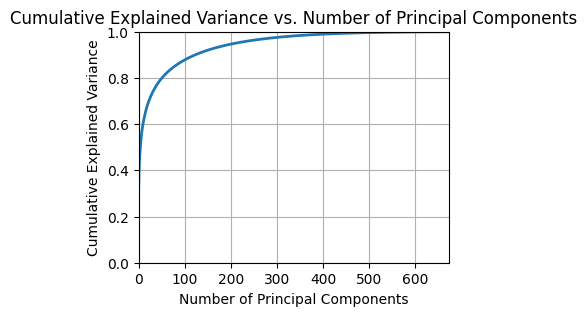

In [14]:
X_flattened = flatten_images(X)
X_flattened_standardized = standardize_data(X_flattened)

def perform_PCA(X):
    cov_matrix = np.cov(X,rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:,sorted_indices]
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    return eigenvalues, eigenvectors, explained_variance_ratio, cumulative_explained_variance

def plot_explained_variance(explained_variance_ratio, cumulative_explained_variance):
    plt.figure(figsize=(4, 3))
    plt.plot(cumulative_explained_variance, linewidth=2)
    plt.axis([0, min(X_flattened.shape[0] ,X_flattened.shape[1]), 0, 1])
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Cumulative Explained Variance vs. Number of Principal Components")
    plt.grid(True)
    plt.show()

eigenvalues, eigenvectors, explained_variance_ratio, cumulative_explained_variance = perform_PCA(X_flattened_standardized)
plot_explained_variance(explained_variance_ratio, cumulative_explained_variance)

In [15]:
def classify_images_logistic_regression(images, labels):
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
    clf = LogisticRegression(max_iter=5000, random_state=42)
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    return accuracy

In [16]:
def knn_classifier(images, labels, n_neighbors=25, test_size=0.2, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=random_state)
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

## Using logistic regression for classificaiton task

In [ ]:
# LOGISTIC REGRESSION
accuracies = np.array([])
for principal_components in range(1, min(X_flattened_standardized.shape[0], X_flattened_standardized.shape[1])):
    reduced_data = np.dot(X_flattened_standardized, eigenvectors[:, :principal_components])
    accuracies = np.append(accuracies, classify_images_logistic_regression(reduced_data, y))

best_acc = classify_images_logistic_regression(X_flattened_standardized, y)
print("Accuracy with all features:", best_acc)

plt.figure(figsize=(4, 3))
plt.plot(accuracies, linewidth=2)
plt.axis([0, min(X_flattened.shape[0] ,X_flattened.shape[1]), 0, 1])
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Principal Components")
plt.grid(True)
plt.show()

## Using KNN for classification task

Accuracy with all features: 0.3925925925925926


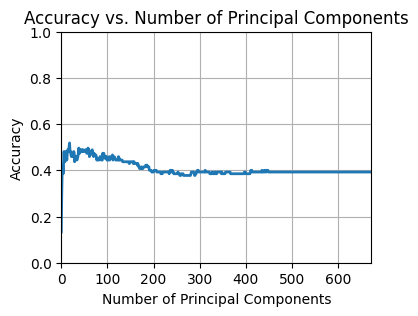

In [18]:
# KNN
accuracies = np.array([])
for principal_components in range(1, min(X_flattened_standardized.shape[0], X_flattened_standardized.shape[1])):
    reduced_data = np.dot(X_flattened_standardized, eigenvectors[:, :principal_components])
    accuracies = np.append(accuracies, knn_classifier(reduced_data, y, n_neighbors=10, random_state=42))

best_acc = knn_classifier(X_flattened_standardized, y, n_neighbors=10, random_state=42)
print("Accuracy with all features:", best_acc)

plt.figure(figsize=(4, 3))
plt.plot(accuracies, linewidth=2)
plt.axis([0, min(X_flattened.shape[0] ,X_flattened.shape[1]), 0, 1])
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Principal Components")
plt.grid(True)
plt.show()

## PCA on the pictionary dataset

In [21]:
pictionary_dataset = np.load('../Data/pictionary.npy', allow_pickle=True)
pictionary_dataset.shape

(1500, 5)

In [24]:
resnet = np.array([row[1] for row in pictionary_dataset]).reshape(-1, 1024)
vit = np.array([row[2] for row in pictionary_dataset]).reshape(-1, 1024)
labels = np.array([row[3] for row in pictionary_dataset])

resnet_trans = resnet.T
vit_trans = vit.T
S_res = np.dot(resnet_trans,resnet_trans.T)
S_vit = np.dot(vit_trans, vit_trans.T)
U_res, D_res, VT_res = np.linalg.svd(S_res)
P_res = U_res.T # our PCA projection matrix

In [26]:
def KNN_Classifier(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    classifier = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro')
    recall = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')

    return accuracy, precision, recall, f1

/Users/arjundosajh/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arjundosajh/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arjundosajh/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arjun

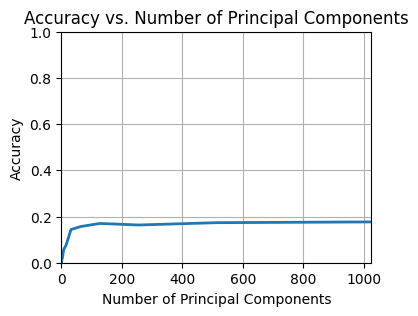

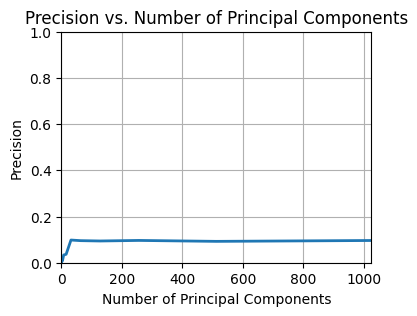

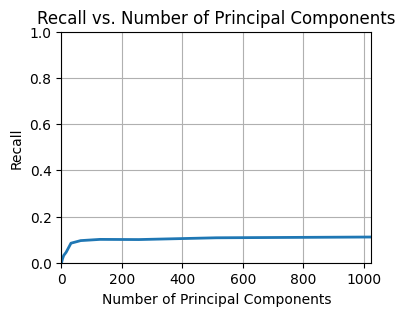

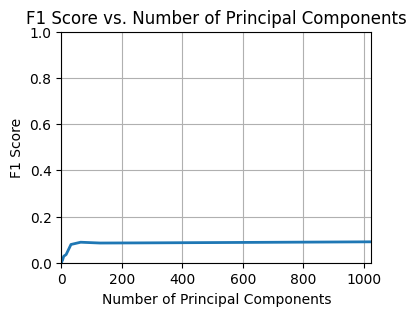

In [34]:
number_of_components = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
accuracy_res = np.array([])
precision_res = np.array([])
recall_res = np.array([])
f1_res = np.array([])

for comp in number_of_components:
    reduced_data = np.dot(resnet, P_res[:, :comp])
    accuracy, precision, recall, f1 = KNN_Classifier(reduced_data, labels)
    accuracy_res = np.append(accuracy_res, accuracy)
    precision_res = np.append(precision_res, precision)
    recall_res = np.append(recall_res, recall)
    f1_res = np.append(f1_res, f1)

plt.figure(figsize=(4, 3))
plt.plot(number_of_components, accuracy_res, linewidth=2)
plt.axis([0, 1024, 0, 1])
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Principal Components")
plt.grid(True)
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(number_of_components, precision_res, linewidth=2)
plt.axis([0, 1024, 0, 1])
plt.xlabel("Number of Principal Components")
plt.ylabel("Precision")
plt.title("Precision vs. Number of Principal Components")
plt.grid(True)
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(number_of_components, recall_res, linewidth=2)
plt.axis([0, 1024, 0, 1])
plt.xlabel("Number of Principal Components")
plt.ylabel("Recall")
plt.title("Recall vs. Number of Principal Components")
plt.grid(True)
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(number_of_components, f1_res, linewidth=2)
plt.axis([0, 1024, 0, 1])
plt.xlabel("Number of Principal Components")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Number of Principal Components")
plt.grid(True)
plt.show()
